In [1]:
cd ~/git/scim

In [2]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import pandas as pd
import anndata
from itertools import cycle

import scanpy as sc
from pathlib import Path
import warnings

from scim.model import VAE, Integrator
from scim.discriminator import SpectralNormCritic
from scim.trainer import Trainer
from scim.utils import switch_obsm, make_network, plot_training, adata_to_pd
from scim.simulate import simulate
from scim.evaluate import score_divergence, extract_matched_labels, get_accuracy, get_confusion_matrix, get_correlation
from scim.matching import get_cost_knn_graph, mcmf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
OUTDIR = Path('./.cache/demo')
SEED = 12
TECHS = ['source', 'target']
LABEL = 'branch'

In [4]:
# PROSSTT params
ngenes = 200
ncells = 20000
tree = '(B:50,C:50)A:50'

In [5]:
# Simulate and cache data

cache = {key: OUTDIR.joinpath('0_data', f'{key}.h5ad') for key in TECHS}

train = dict()
test = dict()
full = dict()

try:
    for tech in TECHS:
        path = cache[tech]
        data = anndata.read(path)
        full[tech] = data
        print(f'Loaded {path}')
        
except OSError:
    print('Error loading, recomputing data')
    np.random.seed(SEED)
    for tech in TECHS:
        data = simulate(tree, ngenes, ncells)
        full[tech] = data
        
        path = cache[tech]
        data.write(cache[tech])
        print(f'Cached {path}')


for tech, data in full.items():
    train[tech] = data[data.obs['is_train']]
    test[tech] = data[~data.obs['is_train']]

# Convert train into tf.data.Datasets
for tech, val in train.items():
    train[tech] = tf.data.Dataset.from_tensor_slices((val.X, val.obs[LABEL].cat.codes, val.obs_names.astype(int)))
    train[tech] = train[tech].batch(256)

# Need to know what the labels are
label_cats = None
for data in full.values():    
    # assert label categories is same on all technologies
    if label_cats is None:
        label_cats = data.obs[LABEL].cat.categories
    else:
        assert label_cats.equals(data.obs[LABEL].cat.categories)

Loaded .cache/demo/0_data/source.h5ad
Loaded .cache/demo/0_data/target.h5ad


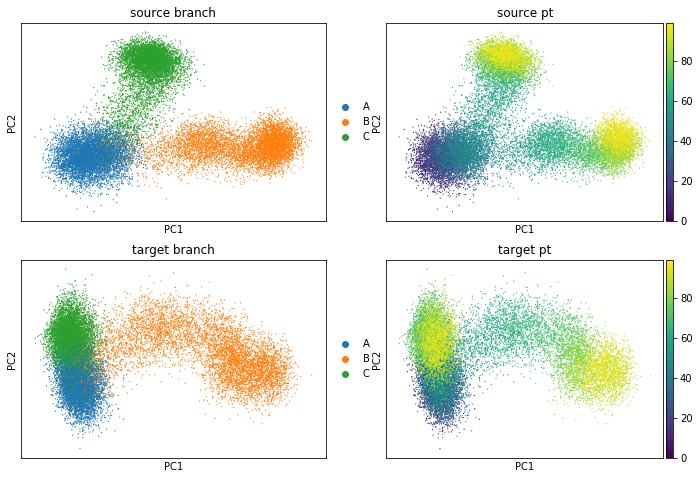

In [6]:
# Visualize simulated data

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, key in enumerate(TECHS):
    for jdx, color in enumerate(['branch', 'pt']):
        ax = axes[idx, jdx]
        sc.pl.pca(full[key], color=color, ax=ax, show=False)
        ax.set_title(f'{key} {color}')
plt.show()

In [7]:
# Set up the model
latent_dim = 8

discriminator_net = make_network(
    doutput=1,
    units=[8]*2,
    dinput=latent_dim + label_cats.size,
    batch_norm=False,
    name='discriminator')

discriminator = SpectralNormCritic(
    discriminator_net,
    input_cats=label_cats)

vae_lut = dict()
for tech in TECHS:
    encoder = make_network(
        doutput=2*latent_dim, 
        units=[32]*2,
        dinput=ngenes,
        batch_norm=True, dropout=0.2,
        name=f'{tech}-encoder')

    decoder = make_network(
        doutput=ngenes,
        units=[32]*2,
        dinput=latent_dim,
        batch_norm=True, dropout=0.2,
        name=f'{tech}-decoder')

    vae_lut[tech] = VAE(
        encoder_net=encoder,
        decoder_net=decoder,
        name=f'{tech}-vae')
    
genopts = {key: tf.keras.optimizers.Adam() for key in TECHS}
disopt = tf.keras.optimizers.Adam()

trainer = Trainer(
    vae_lut=vae_lut,
    discriminator=discriminator,
    source_key='source',
    disopt=disopt,
    genopt_lut=genopts,
    beta=0.5)

In [8]:
# Initialize the latent space by training a VAE on source technology

ckpt_dir = OUTDIR.joinpath('1_init', 'model')


source = 'source'
target = 'target'

try:
    trainer.restore(ckpt_dir)

except AssertionError:
    print('Initializing latent space by training VAE')

    np.random.seed(SEED)
    tf.compat.v1.random.set_random_seed(SEED)

    gs = 0
    for epoch in range(10):
        for (data, dlabel, _), (prior, plabel, _) in zip(train[source], cycle(train[target])):

            # Initializes latent space
            loss, (mse, kl), (codes, recon) = trainer.vae_step(source, data, beta=0.001)

            # Initialize the discriminator
            disc_loss, _ = trainer.discriminator_step(source, target, data, prior, dlabel, plabel)

            # Record
            if gs % 10 == 0:
                lut = {'loss': loss.numpy().mean(),
                       'mse': mse.numpy().mean(),
                       'kl': kl.numpy().mean()}
                trainer.record('vae', lut, step=gs)

            gs = gs + 1

    trainer.saver.save(ckpt_dir.joinpath('ckpt'))

    # Plot training curve
    fig, ax = plt.subplots()
    for key, pairs in trainer.history['vae'].items():
        step, vals = list(zip(*pairs))
        ax.plot(step, vals, label=key)
    ax.legend()
    ax.set_ylim(0, 2)
    plt.show()

else:
    print('Loaded checkpoint')

Loaded checkpoint


Loaded from cache .cache/demo/1_init/source_codes.h5ad


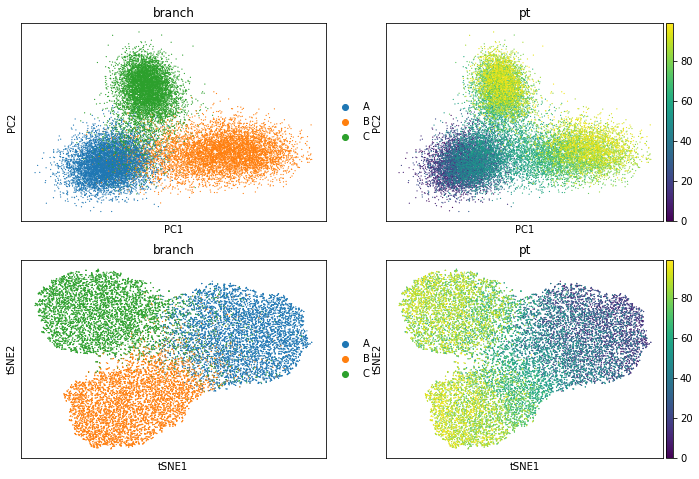

In [9]:
# Visualize the initialized latent space

path = OUTDIR.joinpath('1_init', 'source_codes.h5ad')
path.parent.mkdir(exist_ok=True, parents=True)

try:
    codes = anndata.read(path)
    print(f'Loaded from cache {path}')
    
except OSError:
    print('Cache loading failed')
    
    trainer.forward('source', full['source'], LABEL)
    codes = switch_obsm(full['source'], 'code')
    sc.tl.pca(codes)
    sc.tl.tsne(codes)
    codes.write(path)
    print(f'Caching to {path}')
    

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, key in enumerate(['branch', 'pt']):
    sc.pl.pca(codes, color=key, ax=axes[0, idx], show=False)
    sc.pl.tsne(codes, color=key, ax=axes[1, idx], show=False)
plt.show()

Loaded from cache .cache/demo/1_init/evals.h5ad


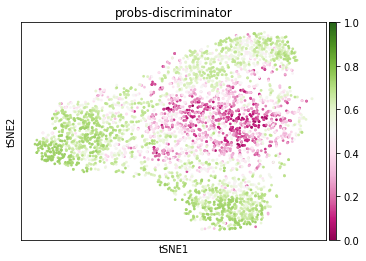

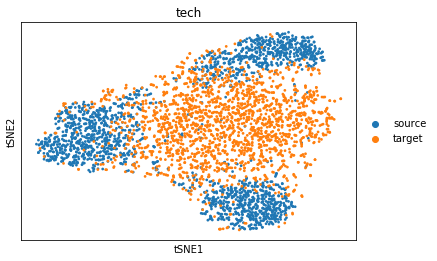

In [10]:
# Visualize discriminator performance on non-aligned latent space
path = OUTDIR.joinpath('1_init', 'evals.h5ad')
path.parent.mkdir(exist_ok=True, parents=True)

try:
    evald = anndata.read(path)
    print(f'Loaded from cache {path}')
    
except OSError:
    print('Cache loading failed')
    evald = trainer.evaluate(test, LABEL)
    sc.tl.tsne(evald)
    evald.write(path)
    print(f'Caching to {path}')
    
sc.pl.tsne(evald, color='probs-discriminator', color_map='PiYG', vmin=0, vmax=1)
sc.pl.tsne(evald, color='tech')

In [11]:
%%time

# Integrate target to source codes
# This might take 5-10 mins

ckpt_dir = OUTDIR.joinpath('2_integrate', 'model')

source = 'target'
target = 'source'
try:
    trainer.restore(ckpt_dir)

except AssertionError:
    print('Training integration')
    np.random.seed(SEED)
    tf.compat.v1.random.set_random_seed(SEED)
    
    gs = 0
    for epoch in range(25):
        for (data, dlabel, didx), (prior, plabel, pidx) in zip(train[source], cycle(train[target])):

            # Train the discriminator
            for _ in range(trainer.niters_discriminator):
                disc_loss, _ = trainer.discriminator_step(source, target, data, prior, dlabel, plabel)

            # Fool adversary & reconstruct
            loss, (nll, adv), (codes, recon) = trainer.adversarial_step(source, data, dlabel)

            # Evaluate training batch, write to trainer.history
            if gs % 5 == 0:
                
                batch = full[source][didx.numpy()]
                trainer.forward(source, batch, LABEL)

                pbatch = full[target][pidx.numpy()]
                trainer.forward(target, pbatch, LABEL)

                lut = {f'mse-{source}': batch.obs['loss-mse'].mean(),
                       f'probs-{source}': batch.obs['probs-discriminator'].mean(),
                       f'probs-{target}': pbatch.obs['probs-discriminator'].mean(),
                       f'discriminator-{source}': batch.obs['loss-discriminator'].mean(),
                       f'discriminator-{target}': pbatch.obs['loss-discriminator'].mean(),
                      }
                trainer.record(f'train', lut, gs)

            # Evaluate testset
            if gs % 50 == 0:
                evald = trainer.evaluate(test, LABEL)
                probs = evald.obs.groupby('tech')['probs-discriminator'].mean()
                dloss = evald.obs.groupby('tech')['loss-discriminator'].mean()
                mse = evald.obs.groupby('tech')['loss-mse'].mean()

                lut = {'divergence': evald.uns['divergence']}
                lut.update({f'probs-{k}': v for k, v in probs.to_dict().items()})
                lut.update({f'mse-{k}': v for k, v in mse.to_dict().items()})
                lut.update({f'discriminator-{k}': v for k, v in dloss.to_dict().items()})

                trainer.record('test', lut, gs)

            gs = gs + 1

    trainer.saver.save(ckpt_dir.joinpath('ckpt'))
    fig, axes = plt.subplots(3, 1, figsize=(5, 9))
    plot_training(trainer, axes)
        
else:
    print('Loaded checkpoint')

Loaded checkpoint
CPU times: user 169 ms, sys: 28.9 ms, total: 198 ms
Wall time: 245 ms


Read from .cache/demo/2_integrate/evals.h5ad


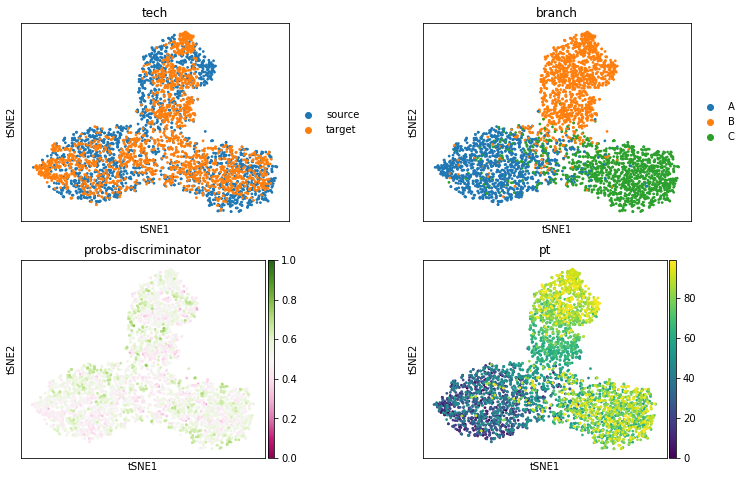

In [12]:
# Integrated latent space

cache = OUTDIR.joinpath('2_integrate', 'evals.h5ad')
try:
    evald = anndata.read(cache)
    print(f'Read from {cache}')
    
except OSError:
    print('Cache loading failed')
    evald = trainer.evaluate(test, LABEL)
    sc.tl.pca(evald)
    sc.tl.tsne(evald, n_jobs=5)
    
    evald.write(cache)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace':0.5})
for color, ax in zip(['tech', 'branch', 'probs-discriminator', 'pt'], axes.ravel()):
    kwargs = {}
    if color == 'probs-discriminator':
        kwargs = {'color_map': 'PiYG', 'vmin':0, 'vmax':1}
    sc.pl.tsne(evald, color=color, ax=ax, show=False, **kwargs)

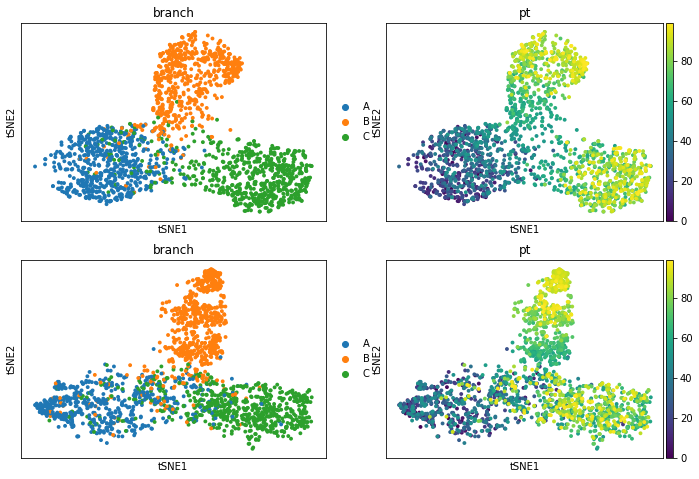

In [13]:
# Visualize integrated latent space

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for key, axl in zip(TECHS, axes):
    mask = evald.obs['tech'] == key
    for color, ax in zip(['branch', 'pt'], axl):
        sc.pl.tsne(evald[mask], color=color, ax=ax, show=False, **kwargs)

In [14]:
# Cache model outputs

trainer.forward(source, full[source], LABEL)
trainer.forward(target, full[target], LABEL)

scode = switch_obsm(full[source], 'code')
tcode = switch_obsm(full[target], 'code')
inter = scode.concatenate(tcode,
                          batch_categories=[source, target],
                          batch_key='tech')


full[source].write(OUTDIR.joinpath('2_integrate', f'{source}.h5ad'))
full[target].write(OUTDIR.joinpath('2_integrate', f'{target}.h5ad'))
inter.write(OUTDIR.joinpath('2_integrate', f'codes.h5ad'))
scode

AnnData object with n_obs × n_vars = 20000 × 8 
    obs: 'pt', 'branch', 'is_train', 'loss-mse', 'loss-kl', 'loss-discriminator', 'probs-discriminator'
    uns: 'pca', 'branch_colors'
    obsm: 'X_pca', 'code', 'recon', 'X'

In [15]:
%%time

cache = OUTDIR.joinpath('3_integrate', 'matches.csv')

try:
    matches = pd.read_csv(cache)
    print(f'Read from cache {cache}')
    
except OSError:
    print(f'Cache loading failed')
    # Perform bipartite matching on the latent embeddings
    # This might take 5-10 mins
    source_pd = adata_to_pd(inter[inter.obs.tech=='source'], add_cell_code_name='source')
    target_pd = adata_to_pd(inter[inter.obs.tech=='target'], add_cell_code_name='target')

    # Build an extended knn graph with k = 10% cells
    G = get_cost_knn_graph(source_pd, target_pd, knn_k=20, null_cost_percentile=95, capacity_method='uniform')

    # Run mcmf and extract matches
    row_ind, col_ind = mcmf(G)
    matches = extract_matched_labels(inter[inter.obs.tech=='source'], inter[inter.obs.tech=='target'],
                                     row_ind, col_ind, keep_cols=['pt','branch'])
    
    cache.parent.mkdir(parents=True, exist_ok=True)
    matches.to_csv(cache, index=False)

    print(f'Caching to {cache}')

Read from cache .cache/demo/3_integrate/matches.csv
CPU times: user 22.1 ms, sys: 887 µs, total: 23 ms
Wall time: 22.6 ms


In [16]:
# Evaluate matches based on branch label
accuracy = get_accuracy(matches, colname_compare='branch')
print('accuracy (branch): ', accuracy)
get_confusion_matrix(matches, colname_compare='branch')

accuracy (branch):  0.8690213392200147


Target,A,B,C
Source,,,
A,4497,411,633
B,255,4580,129
C,544,164,5095


In [17]:
# Evaluate matches based on pseudotime label
spearman, pearson = get_correlation(matches, colname_compare='pt', round_to=2)
print("Spearman's correlation coefficient: "+str(spearman))
print("Pearson's correlation coefficient: "+str(pearson))

Spearman's correlation coefficient: 0.7
Pearson's correlation coefficient: 0.7
